In [3]:

import os, sys
import torch
import numpy as np
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint_adjoint as odeint


from data_preprocessing import DataPreprocessing
from create_torch_datset import CustomDataset
from utils import get_batch, get_device

sys.path.append("/Users/yogeshkawadkar/Documents/sysid-neural-continuous/torchid")

from ssmodels_ct import NeuralStateSpaceModel, DeepNeuralStateSpaceModel
from ss_simulator_ct import ForwardEulerSimulator, ExplicitRKSimulator

device = get_device()

print(f'Using device {device}')

Using device mps


In [4]:
sampling_time_in_seconds = 0.5

In [5]:
path_dataset = "/Users/yogeshkawadkar/Desktop/data_augmentation_for_multivariate_time_series/datasets/Audi a2d2/camera_lidar/20180810_150607/bus/20180810150607_bus_signals.json"
input_signals = [
    'accelerator_pedal',
    'brake_pressure',
    'steering_angle_calculated',
    'steering_angle_calculated_sign',
    # 'pitch_angle',
    # 'roll_angle'
]

output_signals = [
    'acceleration_x',
    'acceleration_y',
    'acceleration_z',
    'angular_velocity_omega_x',
    'angular_velocity_omega_y',
    'angular_velocity_omega_z',
    'vehicle_speed',
    # 'latitude_degree',
    # 'longitude_degree',
]


In [6]:
DP = DataPreprocessing(path_dataset, input_signals, output_signals, sequence_length = 128)
DP.sampling_with_interpolation()
DP.normalize_train()

DP.train_test_split()

t_interp_train, U_train, X_train, t_interp_val, U_val,  X_val = DP.get_train_test_data()

In [2]:
# Setup neural model structure
n_feat = 1024
ss_model = DeepNeuralStateSpaceModel(n_x=len(output_signals), n_u=len(input_signals), n_feat=n_feat).to(device)

# nn_solution = ForwardEulerSimulator(ss_model) #ForwardEulerSimulator(ss_model) #ExplicitRKSimulator(ss_model)
nn_solution = ExplicitRKSimulator(ss_model, ts=sampling_time_in_seconds, device=device) #ForwardEulerSimulator(ss_model) #ExplicitRKSimulator(ss_model)

NameError: name 'DeepNeuralStateSpaceModel' is not defined

In [6]:
# Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Overall parameters
num_iter = 250 # 4*500-100  # gradient-based optimization steps
seq_len = 128
batch_size = 64 # batch size q
lr = 1e-3  # learning rate
test_freq = 1  # print message every test_freq iterations
test_freq_val = 10 * test_freq # do validation every test_freq_val iterations
# add_noise = True

# Setup optimizer
params_net = list(nn_solution.ss_model.parameters())
optimizer = optim.Adam([
    {'params': params_net,    'lr': lr},
    # {'params': params_hidden, 'lr': 10*lr},
], lr=lr)

In [7]:
# Scale loss with respect to the initial one
with torch.no_grad():
    _, batch_u, batch_x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len, device)
    batch_x_sim = nn_solution(batch_x[0], batch_u)
    traced_nn_solution = torch.jit.trace(nn_solution, (batch_x[0], batch_u))
    err_init = batch_x_sim - batch_x
    scale_error = torch.sqrt(torch.mean(err_init**2, dim=(0, 1)))

LOSS = []
VAL_LOSS = []
start_time = time.time()

# Training loop


scripted_nn_solution = torch.jit.script(nn_solution)
for itr in range(0, num_iter):
    
    scripted_nn_solution.train() # Set the model to train model

    optimizer.zero_grad()
    # FIXME
    # optimizer.param_groups[0]['lr'] = lr_scheduler_exp(itr)

    # Simulate
    _, batch_u, batch_x = get_batch(X_train, U_train, t_interp_train, batch_size, seq_len, device)
    #batch_x_sim = traced_nn_solution(batch_x0_hidden, batch_u) # 52 seconds RK | 13 FE
    #batch_x_sim = nn_solution(batch_x0_hidden, batch_u) # 70 seconds RK | 13 FE
    # batch_x_sim = scripted_nn_solution(batch_x0_hidden, batch_u) # 71 seconds RK | 13 FE
    batch_x_sim = scripted_nn_solution(batch_x[0], batch_u) # 71 seconds RK | 13 FE

    # Compute fit loss
    err_fit = batch_x_sim - batch_x
    err_fit_scaled = err_fit/scale_error
    loss = torch.mean(err_fit_scaled**2)

    # Optimize
    loss.backward()
    optimizer.step()
 
    #eval mode
    scripted_nn_solution.eval()
    
    # Validation Performance
    if itr % test_freq_val == 0:
        do_val = True
        _, batch_u_val, batch_x_val = get_batch(X_val, U_val, t_interp_val, 1, U_val.shape[0]-1, device)
        with torch.no_grad(): 
        #with torch.inference_mode():    
            batch_x_sim_val = scripted_nn_solution(batch_x_val[0], batch_u_val) # 71 seconds RK | 13 FE
            loss_val = torch.mean(((batch_x_sim_val - batch_x_val) / scale_error)**2)
            VAL_LOSS.append(loss_val.item())
    
    # Statistics
    LOSS.append(loss.item())
    if itr % test_freq == 0:
        #with torch.inference_mode():
        with torch.no_grad():
            if do_val:
                print(f'\rIter {itr} | Loss {loss:.4f}  Val Loss {loss_val} ', end='\n')
                do_val = False
            else:
                print(f'\rIter {itr} | Loss {loss:.4f}  ', end='')

train_time = time.time() - start_time
print(f"\nTrain time: {train_time:.2f}") 

Iter 0 | Loss 0.9483  Val Loss 2.633734941482544 
Iter 10 | Loss 0.7018  Val Loss 4.922149181365967 
Iter 20 | Loss 0.4346  Val Loss 4.00596809387207 
Iter 30 | Loss 0.3499  Val Loss 2.275444984436035 
Iter 40 | Loss 0.2599  Val Loss 1.1650722026824951 
Iter 50 | Loss 0.2690  Val Loss 1.089611291885376 
Iter 60 | Loss 0.2434  Val Loss 0.9365235567092896 
Iter 70 | Loss 0.2313  Val Loss 2.404911518096924 
Iter 80 | Loss 0.2350  Val Loss 1.5177621841430664 
Iter 90 | Loss 0.2477  Val Loss 1.0962138175964355 
Iter 100 | Loss 0.2330  Val Loss 1.0959004163742065 
Iter 110 | Loss 0.2246  Val Loss 1.2368831634521484 
Iter 120 | Loss 0.2090  Val Loss 0.8846481442451477 
Iter 130 | Loss 0.2114  Val Loss 0.8365290760993958 
Iter 140 | Loss 0.2184  Val Loss 0.8359457850456238 
Iter 150 | Loss 0.2163  Val Loss 0.8308271169662476 
Iter 160 | Loss 0.2064  Val Loss 0.8178334832191467 
Iter 170 | Loss 0.2217  Val Loss 0.8851973414421082 
Iter 180 | Loss 0.2187  Val Loss 0.8104138970375061 
Iter 190 | 

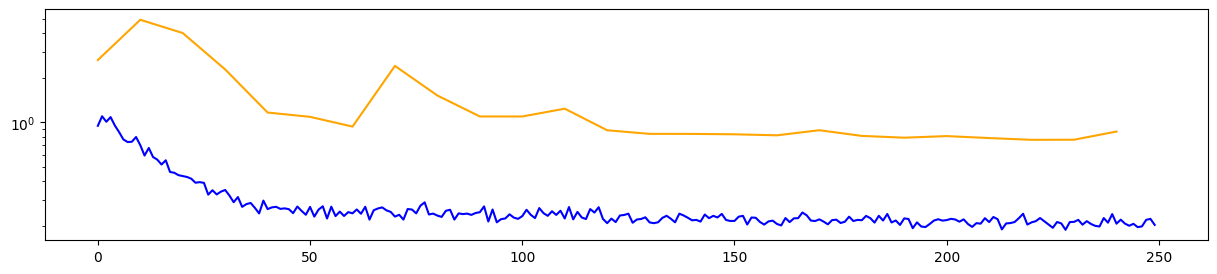

In [8]:
plt.figure(figsize=(15,3))
plt.plot(LOSS, label='loss', color='blue')
# plt.yscale('log')
# plt.figure(figsize=(15,3))
# plt.plot(VAL_LOSS, label='loss', color='orange')
plt.plot(np.arange(0, num_iter, test_freq_val/test_freq), VAL_LOSS, label='loss', color='orange')
plt.yscale('log')

# plt.plot(LOSS_CONSISTENCY, label='consistency loss')
# plt.plot(LOSS_FIT, label='fit loss')
# plt.legend()
plt.show()

In [14]:
print(f'min(LOSS): {np.min(LOSS)}')
print(f'min(VAL_LOSS): {np.min(VAL_LOSS)}')
print(f'argmin(LOSS): {np.argmin(LOSS)}')
print(f'argmin(VAL_LOSS): {np.argmin(VAL_LOSS) * test_freq_val}')

min(LOSS): 0.27821630239486694
min(VAL_LOSS): 0.6989989280700684
argmin(LOSS): 240
argmin(VAL_LOSS): 220


In [15]:
def predict(x, u):
    x0 = x[0].astype('float32')
    x0_torch = torch.from_numpy(x0).to(device)
    u_torch = torch.tensor(u.astype('float32')).to(device)

    with torch.no_grad():
        x_sim_torch = nn_solution(x0_torch[None, :], u_torch[:, None, :])
        x_sim = x_sim_torch.squeeze(1).cpu().numpy()

    return x_sim

In [16]:
X_train_sim = predict(X_train, U_train)
X_val_sim = predict(X_val, U_val)

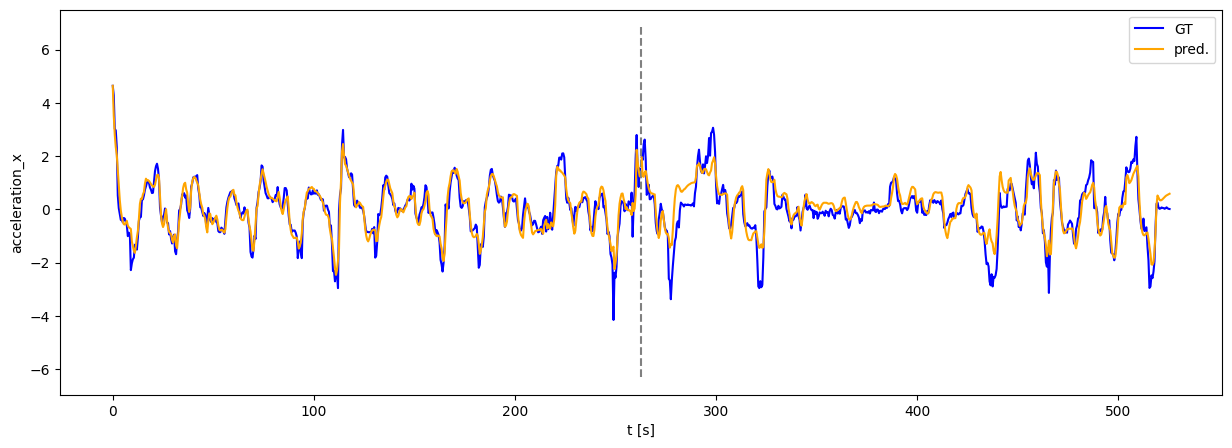

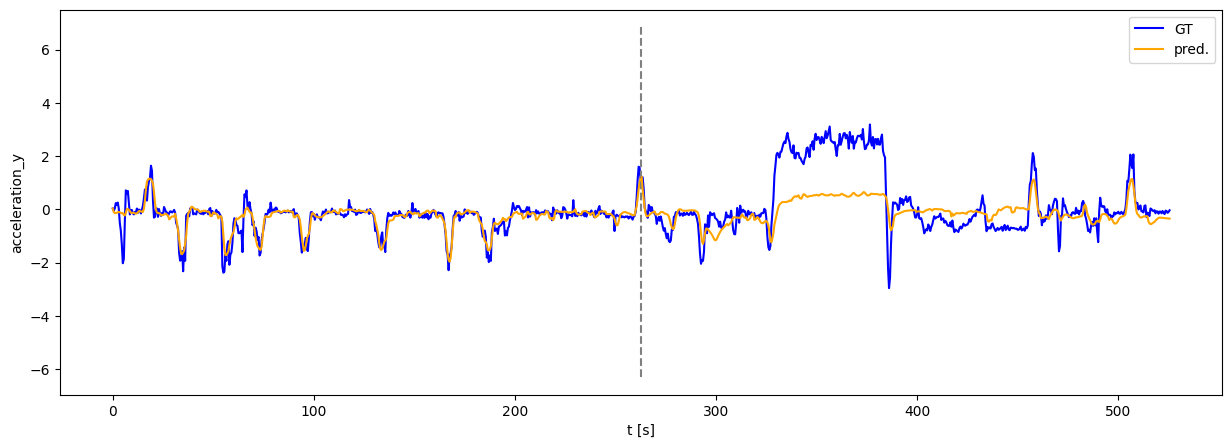

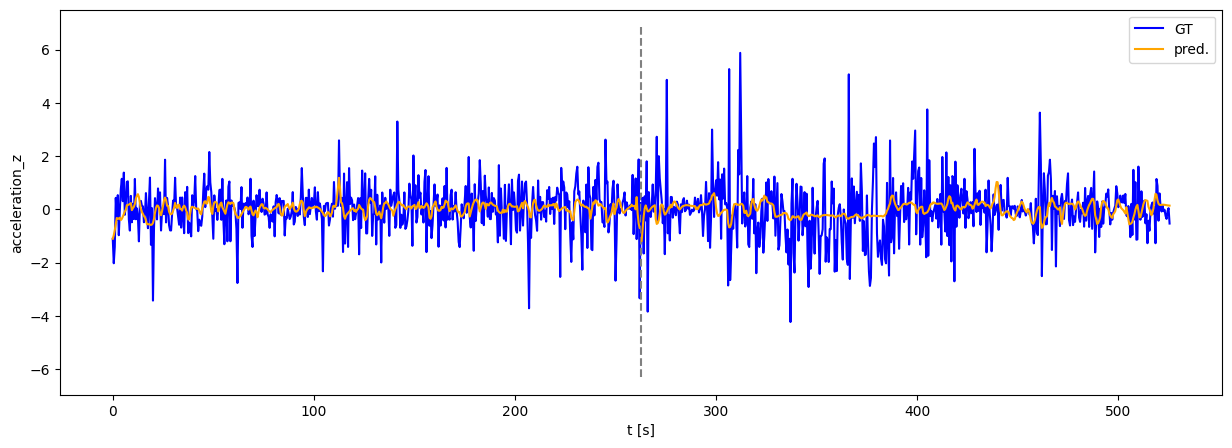

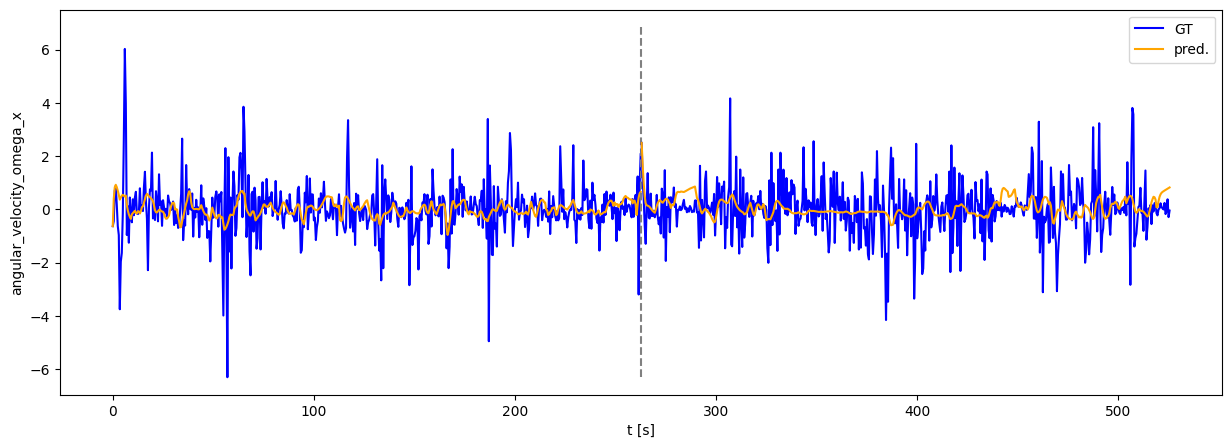

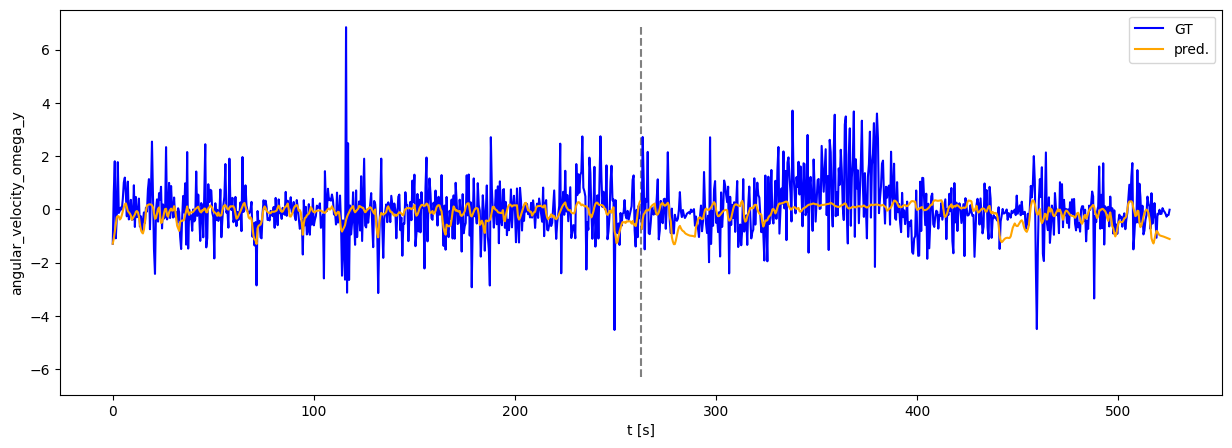

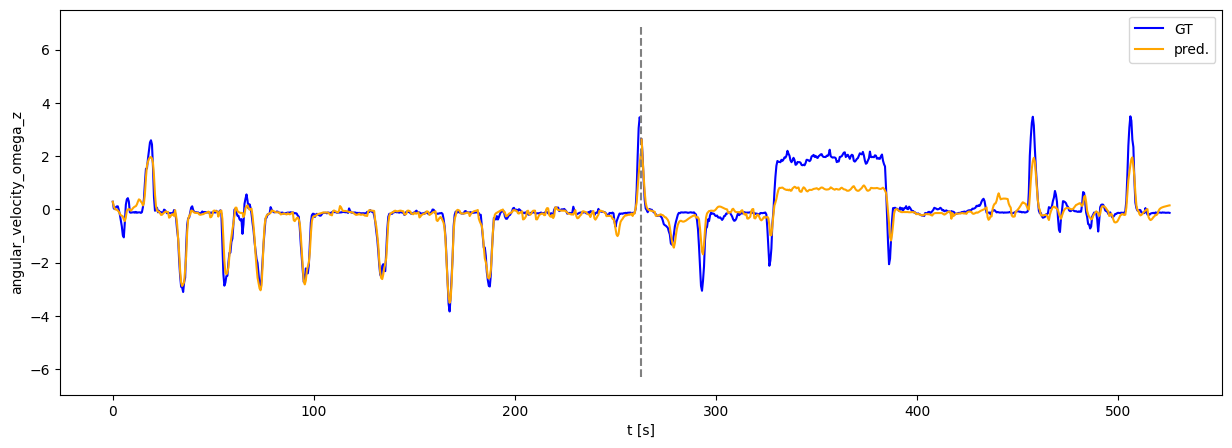

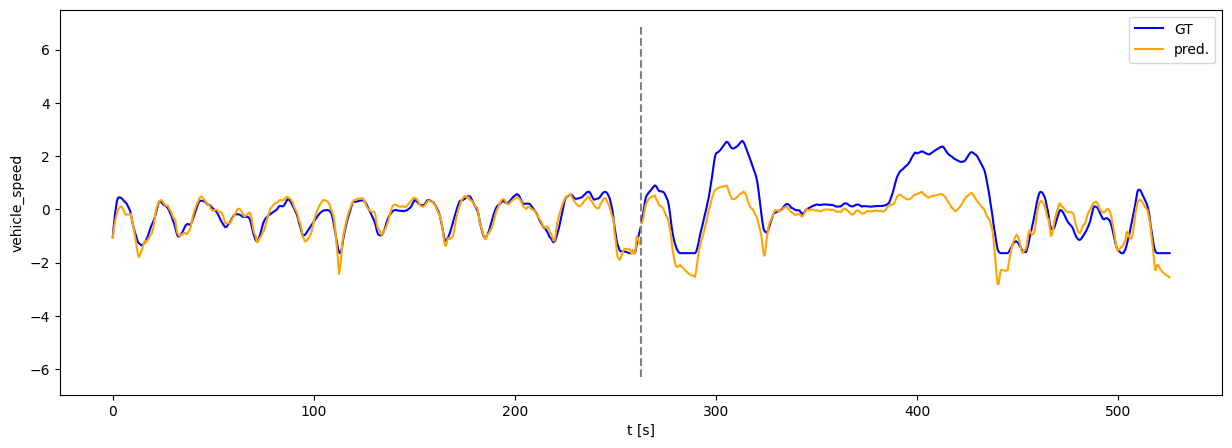

In [17]:
T = None

for i in range(len(output_signals)):
    plt.figure(figsize=(15,5))
    plt.plot(t_interp_train, X_train[:, i], label='GT', color='blue')
    plt.plot(t_interp_train, X_train_sim[:, i], label='pred.', color='orange')
    plt.plot([t_interp_train[-1]]*2, [np.min(X_train), np.max(X_train)], color='gray', linestyle='--')
    plt.plot(t_interp_val[:T], X_val[:T,i], color='blue')
    plt.plot(t_interp_val[:T], X_val_sim[:T,i], color='orange')
    plt.xlabel('t [s]')
    plt.ylabel(f'{output_signals[i]}')
    plt.legend()
    plt.show()

1052